In [ ]:
# To unzip
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/Colab Notebooks/Melanoma_Skin_Cancer_Detection/dataset.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

done


# Split dataset to Train, Validate and Test

In [ ]:
!pip install split-folders

import splitfolders
splitfolders.ratio(r"/content/raw/train",  # "/content/processed/train"
                   'data',
                   seed = 41,
                   ratio = (0.6, 0.25, 0.15)) # train/val/test

Copying files: 9605 files [00:01, 7630.52 files/s]


# Start to Training

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16, MobileNet, ResNet50, DenseNet121, InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [ ]:
# Function to create a model with a given base model
def create_transfer_learning_model(base_model, num_classes):
    base_model.trainable = False  # Freeze base model layers
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax' if num_classes > 1 else 'sigmoid')(x)
    model = Model(inputs, outputs)
    return model

# Function to train a specific model
def train_model(model, train_generator, val_generator, epochs=10, learning_rate=0.001):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy' if train_generator.num_classes > 1 else 'binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=epochs,
                        steps_per_epoch=100)

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)

    accuracy_image_path = 'accuracy_plot.png'
    plt.plot(epochs, acc, label='training accuracy')
    plt.plot(epochs, val_acc, label='validation accuracy')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title('Training validation Accuracy')
    plt.savefig(accuracy_image_path, bbox_inches='tight')
    plt.show()

    loss_image_path = 'loss_plot.png'
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend()
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title('Training validation Loss')
    plt.savefig(loss_image_path, bbox_inches='tight')
    plt.show()

    return model, history

# Functions to create specific models
def create_vgg16_model(num_classes):
    return create_transfer_learning_model(VGG16(weights='imagenet', include_top=False), num_classes)

def create_mobilenet_model(num_classes):
    return create_transfer_learning_model(MobileNet(weights='imagenet', include_top=False), num_classes)

def create_resnet50_model(num_classes):
    return create_transfer_learning_model(ResNet50(weights='imagenet', include_top=False), num_classes)

def create_densenet_model(num_classes):
    return create_transfer_learning_model(DenseNet121(weights='imagenet', include_top=False), num_classes)

def create_inceptionv3_model(num_classes):
    return create_transfer_learning_model(InceptionV3(weights='imagenet', include_top=False), num_classes)

# Function to save the model
def save_model(model, filepath):
    model.save(filepath)
    print(f"Model saved to {filepath}")

# Function to load the model
def load_model(filepath):
    model = tf.keras.models.load_model(filepath)
    print(f"Model loaded from {filepath}")
    return model

# Function to evaluate the model
def evaluate_model(model, test_generator):
    predictions = model.predict(test_generator)

    predicted_classes = np.argmax(predictions, axis=1) if test_generator.num_classes > 1 else (predictions > 0.5).astype(int)

    # Handle binary and multiclass cases
    # if test_generator.num_classes > 1:  # Multiclass classification
    #     predicted_classes = np.argmax(predictions, axis=1)
    # else:  # Binary classification
    #     predicted_classes = (predictions > 0.5).astype(int).flatten()

    true_classes = test_generator.classes
    # class_indices = test_generator.class_indices

    # Metrics
    acc = accuracy_score(true_classes, predicted_classes)
    loss = 1 - acc
    cm = confusion_matrix(true_classes, predicted_classes)
    cr = classification_report(true_classes, predicted_classes)
    kappa = cohen_kappa_score(true_classes, predicted_classes)

    print(f"Accuracy: {acc}")
    print(f"Loss: {loss}")
    print(f"Cohen Kappa Score: {kappa}")
    print("Classification Report:")
    print(cr)

    # Plot confusion matrix heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_generator.class_indices.keys(),
                yticklabels=test_generator.class_indices.keys())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()

    return acc, kappa, cm, cr

# Function to prepare data generators
def prepare_data_generators(train_dir, val_dir, test_dir, target_size=(224, 224), batch_size=32):
    datagen = ImageDataGenerator(rescale=1.0/255)
    train_generator = datagen.flow_from_directory(train_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical')
    val_generator = datagen.flow_from_directory(val_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical')
    test_generator = datagen.flow_from_directory(test_dir, target_size=target_size, batch_size=batch_size, class_mode='categorical', shuffle=False)
    return train_generator, val_generator, test_generator


# VGG16

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 281ms/step - accuracy: 0.7242 - loss: 0.5333 - val_accuracy: 0.8130 - val_loss: 0.4328
Epoch 2/100
 81/100 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 0.8448 - loss: 0.3963

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - accuracy: 0.8445 - loss: 0.3926 - val_accuracy: 0.8376 - val_loss: 0.3671
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 236ms/step - accuracy: 0.8423 - loss: 0.3638 - val_accuracy: 0.8517 - val_loss: 0.3392
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.8533 - loss: 0.3347 - val_accuracy: 0.8642 - val_loss: 0.3217
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 23s 224ms/step - accuracy: 0.8511 - loss: 0.3470 - val_accuracy: 0.8455 - val_loss: 0.3382
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 21s 208ms/step - accuracy: 0.8757 - loss: 0.2988 - val_accuracy: 0.8659 - val_loss: 0.3214
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 234ms/step - accuracy: 0.8733 - loss: 0.2990 - val_accuracy: 0.8788 - val_loss: 0.2915
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.8797 - loss: 0.2905 - val_accuracy: 0.8855 - val_loss: 0.2820
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 234ms/step - accuracy: 0.8901 - loss: 0.265

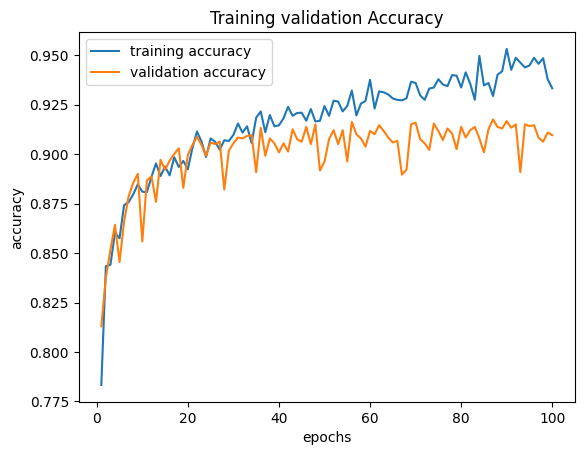

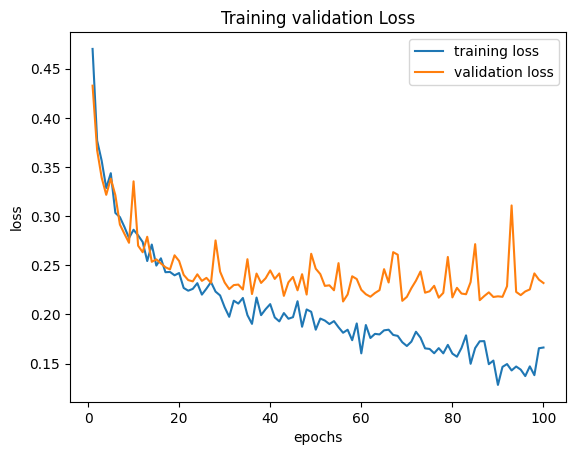

Model saved to vgg16_model.h5
Model loaded from vgg16_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 140ms/step
Accuracy: 0.9083969465648855
Loss: 0.09160305343511455
Cohen Kappa Score: 0.8168407308190805
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       750
           1       0.89      0.93      0.91       691

    accuracy                           0.91      1441
   macro avg       0.91      0.91      0.91      1441
weighted avg       0.91      0.91      0.91      1441



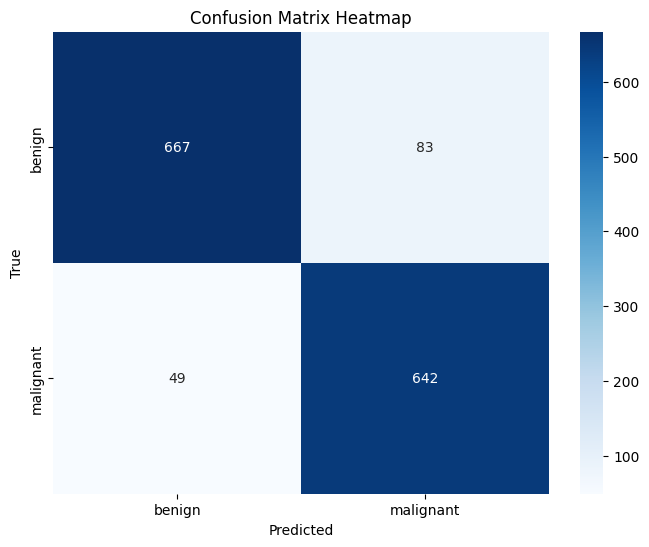

In [ ]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = "/content/data/train"
    val_dir = "/content/data/val"
    test_dir = "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    vgg16_model = create_vgg16_model(num_classes)
    trained_vgg16, _ = train_model(vgg16_model, train_gen, val_gen, epochs=100)
    save_model(trained_vgg16, "vgg16_model.h5")
    # save_model(trained_vgg16, "vgg16_model.keras")

    # Load and evaluate VGG16 model
    loaded_vgg16 = load_model("vgg16_model.h5")
    evaluate_model(loaded_vgg16, test_gen)

# Mobilenet

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.


<ipython-input-4-68ec2b2c28be>:59: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  return create_transfer_learning_model(MobileNet(weights='imagenet', include_top=False), num_classes)


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 26s 195ms/step - accuracy: 0.8111 - loss: 0.4449 - val_accuracy: 0.9055 - val_loss: 0.2467
Epoch 2/100
 80/100 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9079 - loss: 0.2369

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9074 - loss: 0.2390 - val_accuracy: 0.8905 - val_loss: 0.2505
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 107ms/step - accuracy: 0.9086 - loss: 0.2296 - val_accuracy: 0.9109 - val_loss: 0.2275
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.9031 - loss: 0.2285 - val_accuracy: 0.9042 - val_loss: 0.2351
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - accuracy: 0.9323 - loss: 0.1750 - val_accuracy: 0.9113 - val_loss: 0.2321
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9379 - loss: 0.1649 - val_accuracy: 0.9121 - val_loss: 0.2335
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - accuracy: 0.9386 - loss: 0.1552 - val_accuracy: 0.9184 - val_loss: 0.2192
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - accuracy: 0.9410 - loss: 0.1408 - val_accuracy: 0.9138 - val_loss: 0.2247
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 88ms/step - accuracy: 0.9440 - loss: 0.1415 - val_a

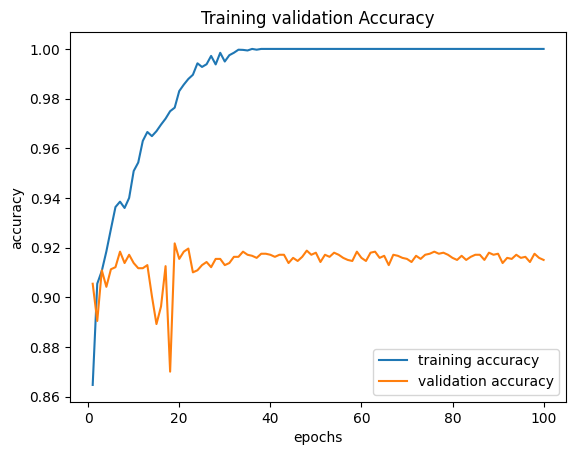

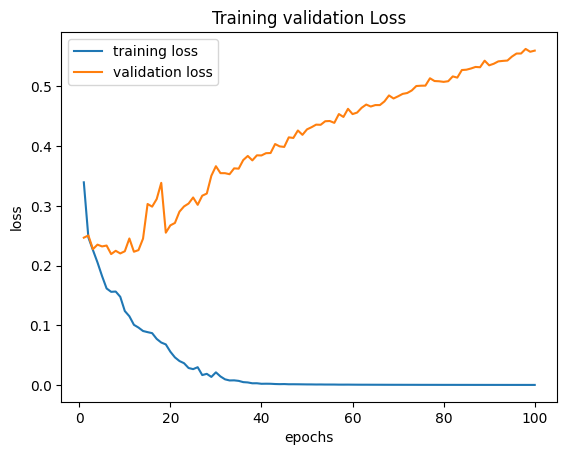

Model saved to mobilenet_model.h5


Model loaded from mobilenet_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step
Accuracy: 0.9201943095072866
Loss: 0.07980569049271335
Cohen Kappa Score: 0.8400750816682028
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.92       750
           1       0.92      0.91      0.92       691

    accuracy                           0.92      1441
   macro avg       0.92      0.92      0.92      1441
weighted avg       0.92      0.92      0.92      1441



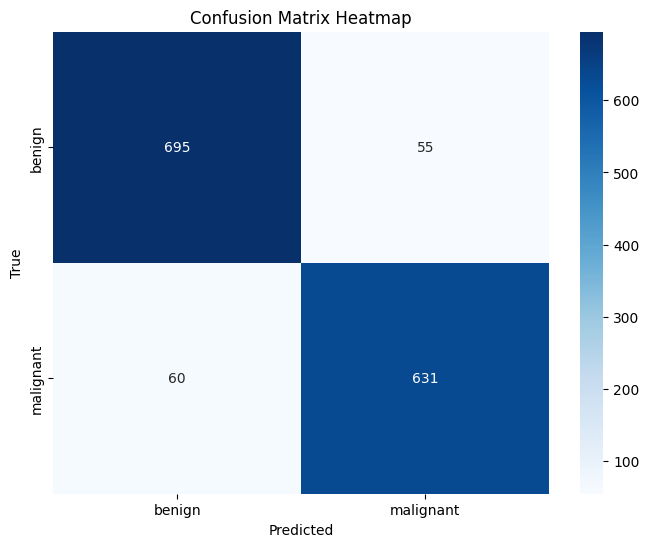

In [ ]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = "/content/data/train"
    val_dir = "/content/data/val"
    test_dir = "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    mobilenet_model = create_mobilenet_model(num_classes)
    trained_mobilenet, _ = train_model(mobilenet_model, train_gen, val_gen, epochs=100)
    save_model(trained_mobilenet, "mobilenet_model.h5")

    # Load and evaluate VGG16 model
    loaded_mobilenet = load_model("mobilenet_model.h5")
    evaluate_model(loaded_mobilenet, test_gen)

# Resnet50

In [ ]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = "/content/data/train"
    val_dir = "/content/data/val"
    test_dir = "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    resnet50_model = create_resnet50_model(num_classes)
    trained_resnet50, _ = train_model(resnet50_model, train_gen, val_gen, epochs=100)
    save_model(trained_resnet50, "resnet50_model.h5")

    # Load and evaluate VGG16 model
    loaded_resnet50 = load_model("resnet50_model.h5")
    evaluate_model(loaded_resnet50, test_gen)

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 35s 226ms/step - accuracy: 0.5232 - loss: 0.7583 - val_accuracy: 0.5314 - val_loss: 0.7161
Epoch 2/100
 81/100 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 0.6009 - loss: 0.6591

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 20s 202ms/step - accuracy: 0.6027 - loss: 0.6567 - val_accuracy: 0.5015 - val_loss: 0.6483
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 50s 152ms/step - accuracy: 0.6165 - loss: 0.6460 - val_accuracy: 0.6918 - val_loss: 0.6007
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - accuracy: 0.6709 - loss: 0.6043 - val_accuracy: 0.6064 - val_loss: 0.6333
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.7080 - loss: 0.5887 - val_accuracy: 0.7055 - val_loss: 0.5667
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.7377 - loss: 0.5521 - val_accuracy: 0.5481 - val_loss: 0.6168
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 0.7118 - loss: 0.5566 - val_accuracy: 0.7205 - val_loss: 0.5382
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.7197 - loss: 0.5517 - val_accuracy: 0.7343 - val_loss: 0.5286
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.7358 - loss: 0.529

# Densenet

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 53s 341ms/step - accuracy: 0.8087 - loss: 0.3930 - val_accuracy: 0.8563 - val_loss: 0.3371
Epoch 2/100
 81/100 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.8742 - loss: 0.3042

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 18s 179ms/step - accuracy: 0.8762 - loss: 0.3001 - val_accuracy: 0.8821 - val_loss: 0.2802
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.8788 - loss: 0.2949 - val_accuracy: 0.8971 - val_loss: 0.2515
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.8990 - loss: 0.2535 - val_accuracy: 0.8934 - val_loss: 0.2581
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - accuracy: 0.9025 - loss: 0.2480 - val_accuracy: 0.8975 - val_loss: 0.2523
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 0.9048 - loss: 0.2259 - val_accuracy: 0.9000 - val_loss: 0.2458
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 163ms/step - accuracy: 0.9098 - loss: 0.2103 - val_accuracy: 0.8980 - val_loss: 0.2470
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 138ms/step - accuracy: 0.9075 - loss: 0.2220 - val_accuracy: 0.9009 - val_loss: 0.2450
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step - accuracy: 0.9047 - loss: 0.215

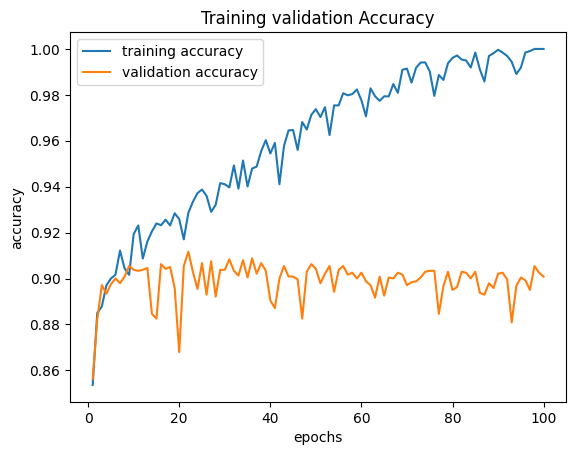

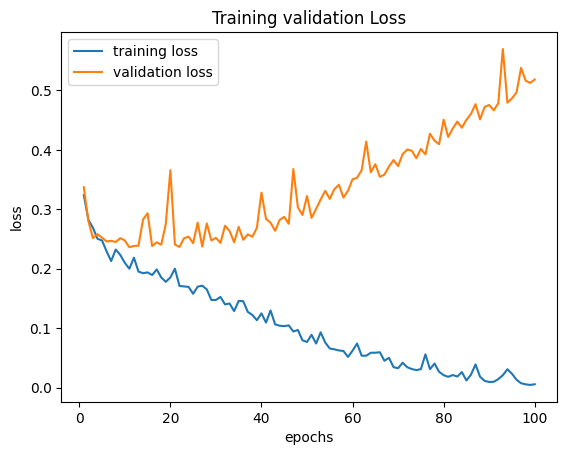

Model saved to densenet_model.h5


Model loaded from densenet_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step
Accuracy: 0.8896599583622484
Loss: 0.11034004163775157
Cohen Kappa Score: 0.7790373927224367
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       750
           1       0.88      0.89      0.89       691

    accuracy                           0.89      1441
   macro avg       0.89      0.89      0.89      1441
weighted avg       0.89      0.89      0.89      1441



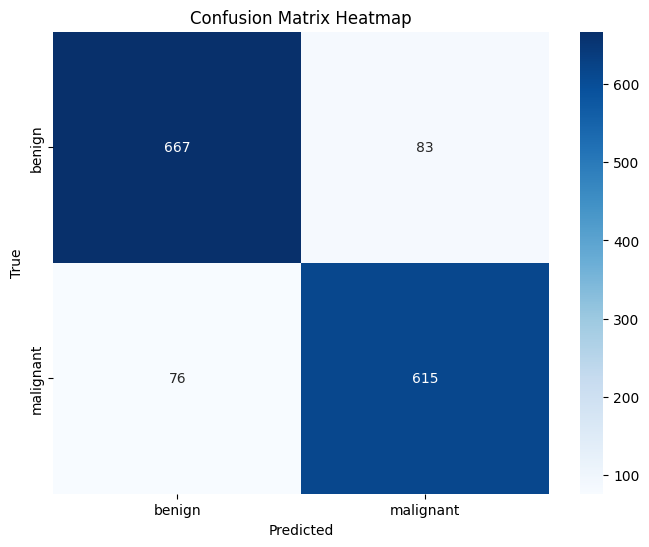

In [ ]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = "/content/data/train"
    val_dir = "/content/data/val"
    test_dir = "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    densenet_model = create_densenet_model(num_classes)
    trained_densenet, _ = train_model(densenet_model, train_gen, val_gen, epochs=100)
    save_model(trained_densenet, "densenet_model.h5")

    # Load and evaluate VGG16 model
    loaded_densenet = load_model("densenet_model.h5")
    evaluate_model(loaded_densenet, test_gen)

# Inceptionv3

Found 5763 images belonging to 2 classes.
Found 2401 images belonging to 2 classes.
Found 1441 images belonging to 2 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


100/100 ━━━━━━━━━━━━━━━━━━━━ 46s 269ms/step - accuracy: 0.7467 - loss: 0.6546 - val_accuracy: 0.8576 - val_loss: 0.3232
Epoch 2/100
 81/100 ━━━━━━━━━━━━━━━━━━━━ 2s 152ms/step - accuracy: 0.8549 - loss: 0.3307

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - accuracy: 0.8562 - loss: 0.3278 - val_accuracy: 0.8559 - val_loss: 0.3184
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 0.8930 - loss: 0.2603 - val_accuracy: 0.8688 - val_loss: 0.2945
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 168ms/step - accuracy: 0.8923 - loss: 0.2526 - val_accuracy: 0.8684 - val_loss: 0.3018
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - accuracy: 0.8801 - loss: 0.2834 - val_accuracy: 0.8676 - val_loss: 0.2876
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 137ms/step - accuracy: 0.8848 - loss: 0.2696 - val_accuracy: 0.8742 - val_loss: 0.2781
Epoch 7/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 28s 157ms/step - accuracy: 0.8961 - loss: 0.2505 - val_accuracy: 0.8626 - val_loss: 0.2969
Epoch 8/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 141ms/step - accuracy: 0.9053 - loss: 0.2245 - val_accuracy: 0.8767 - val_loss: 0.2823
Epoch 9/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 157ms/step - accuracy: 0.9145 - loss: 0.208

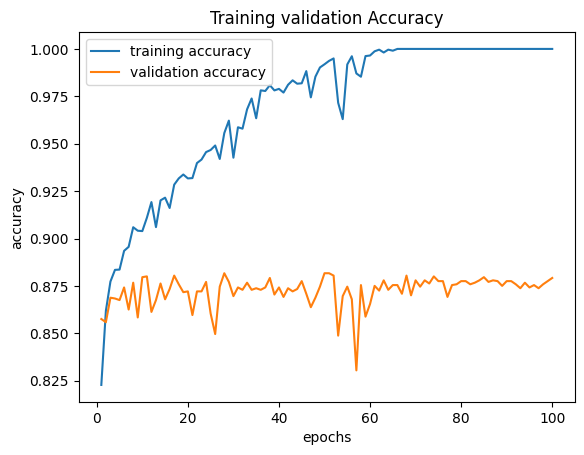

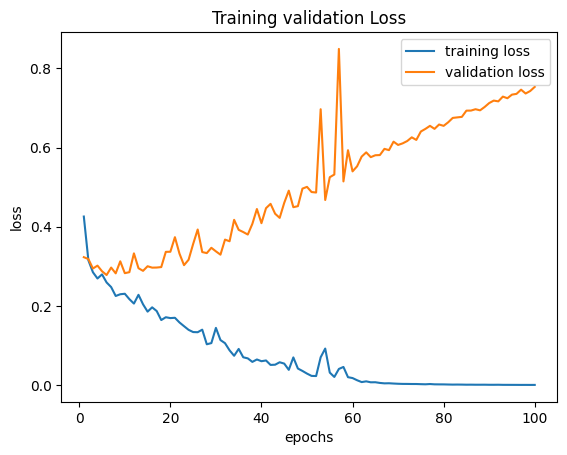

Model saved to inceptionv3_model.h5


Model loaded from inceptionv3_model.h5
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step
Accuracy: 0.871616932685635
Loss: 0.128383067314365
Cohen Kappa Score: 0.7427587730852254
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       750
           1       0.87      0.86      0.87       691

    accuracy                           0.87      1441
   macro avg       0.87      0.87      0.87      1441
weighted avg       0.87      0.87      0.87      1441



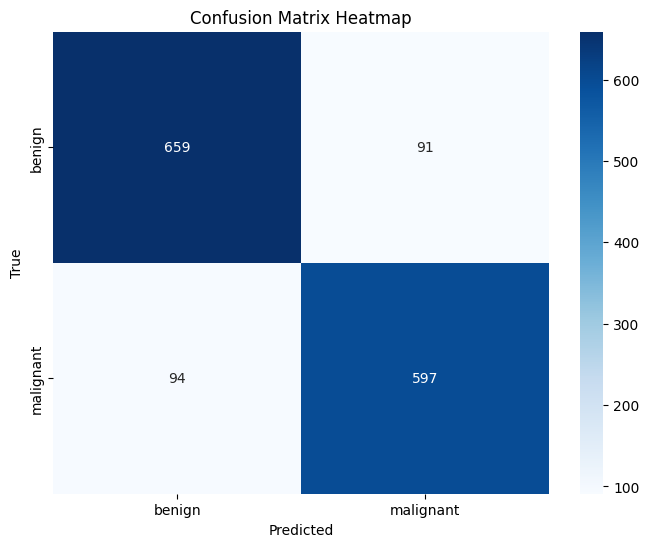

In [ ]:
if __name__ == "__main__":
    # Paths to your data directories
    train_dir = "/content/data/train"
    val_dir = "/content/data/val"
    test_dir = "/content/data/test"

    # Prepare data
    train_gen, val_gen, test_gen = prepare_data_generators(train_dir, val_dir, test_dir)

    # Choose number of classes
    num_classes = train_gen.num_classes

    # Train VGG16 model
    inceptionv3_model = create_inceptionv3_model(num_classes)
    trained_inceptionv3, _ = train_model(inceptionv3_model, train_gen, val_gen, epochs=100)
    save_model(trained_inceptionv3, "inceptionv3_model.h5")

    # Load and evaluate VGG16 model
    loaded_inceptionv3 = load_model("inceptionv3_model.h5")
    evaluate_model(loaded_inceptionv3, test_gen)

# Deployment

In [2]:
!pip install tensorflow opencv-python-headless streamlit numpy pillow


In [21]:
%%writefile app.py
import streamlit as st
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from PIL import Image

# Function to preprocess the image (including the inverse_masked_area)
def preprocess_image(image_path):
    """
    Preprocess the image and return the inverse masked area.

    Parameters:
        image_path (str): Path to the input image.

    Returns:
        inverse_masked_image (ndarray): Image with inverse masked area.
        processing_stages_path (str): Path to saved 'processing_stages.png'.
    """
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)

    # Convert to 256x256 grayscale
    gray_image = cv2.cvtColor(cv2.resize(image, (256, 256)), cv2.COLOR_BGR2GRAY)

    # Apply BM3D filtering
    denoised_image = cv2.fastNlMeansDenoising(gray_image, None, 10, 7, 21)

    # Apply binary thresholding
    _, binary_mask = cv2.threshold(denoised_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Perform morphological operations
    kernel = np.ones((5, 5), np.uint8)
    morphed_image = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel)

    # Extract the masked area
    masked_area = cv2.bitwise_and(gray_image, gray_image, mask=morphed_image)

    # Extract the inverse of the masked area
    inverse_mask = cv2.bitwise_not(morphed_image)
    inverse_masked_area = cv2.bitwise_and(gray_image, gray_image, mask=inverse_mask)

    # Save all stages for visualization
    processing_stages_path = "processing_stages.png"
    stages = np.hstack((gray_image, morphed_image, masked_area, inverse_masked_area))
    cv2.imwrite(processing_stages_path, stages)

    return inverse_masked_area, processing_stages_path

# Prediction function using VGG16
def predict(image, model):
    """
    Predict using a pre-trained VGG16 model.

    Parameters:
        image (ndarray): Preprocessed image (inverse masked area).
        model (keras.Model): Pre-trained VGG16 model.

    Returns:
        str: Prediction result (e.g., 'Benign' or 'Malignant').
    """
    # Resize the image to match VGG16 input size (224x224)
    image_resized = cv2.resize(image, (224, 224))

    # Convert to 3-channel image (VGG16 expects RGB input)
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_GRAY2RGB)

    # Convert to array and preprocess for VGG16
    image_array = img_to_array(image_rgb)
    image_array = np.expand_dims(image_array, axis=0)
    image_preprocessed = preprocess_input(image_array)

    # Predict using the model
    predictions = model.predict(image_preprocessed)

    # Assume binary classification: class 0 = 'Benign', class 1 = 'Malignant'
    predicted_class = np.argmax(predictions, axis=1)[0]
    return "Malignant" if predicted_class == 1 else "Benign"

# Streamlit app
def main():
    st.title("Melanoma Skin Cancer Detection")
    st.write("Upload an image to detect melanoma skin cancer.")

    # Input image folder
    input_folder = "uploaded_images"
    if not os.path.exists(input_folder):
        os.makedirs(input_folder)

    # Load pre-trained VGG16 model
    # base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
    # # Add custom classification layers
    # x = base_model.output
    # x = tf.keras.layers.Flatten()(x)
    # x = tf.keras.layers.Dense(256, activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    # predictions = tf.keras.layers.Dense(2, activation='softmax')(x)
    # vgg16_model = Model(inputs=base_model.input, outputs=predictions)
    # vgg16_model.load_weights("/content/processed_resnet50_model.h5")  # Load custom-trained weights

    vgg16_model = load_model(r'/content/processed_resnet50_model.h5')

    # File uploader
    uploaded_file = st.file_uploader("Choose an image", type=["jpg", "jpeg", "png"])

    if uploaded_file is not None:
        # Save the uploaded image
        image_path = os.path.join(input_folder, uploaded_file.name)
        with open(image_path, "wb") as f:
            f.write(uploaded_file.getbuffer())
        st.success(f"Image saved at {image_path}")

        # Display the uploaded image
        st.image(image_path, caption="Uploaded Image", use_column_width=True)

        # Preprocess the image
        st.write("Processing the image...")
        inverse_masked_image, processing_stages_path = preprocess_image(image_path)

        # Show processing stages
        st.write("Processing stages:")
        st.image(processing_stages_path, caption="Processing Stages", use_column_width=True)

        # Perform prediction
        st.write("Predicting...")
        result = predict(inverse_masked_image, vgg16_model)

        # Display the prediction result
        st.write(f"**Prediction Result:** {result}")

# Run the app
if __name__ == "__main__":
    main()


Overwriting app.py


In [22]:
!npm install localtunnel

⠙⠹⠸⠼⠴⠦
up to date, audited 23 packages in 1s
⠧
⠧3 packages are looking for funding
⠧  run `npm fund` for details
⠧
2 moderate severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠧

 35.197.82.8

In [ ]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

# !streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501
# !streamlit run app.py --server.address=localhost &>/content/logs.txt & npx localtunnel --port 8501
!streamlit run app.py & npx localtunnel --port 8501

# !pip install pyngrok
# from pyngrok import ngrok
# public_url = ngrok.connect(port='8501')
# print(public_url)
# !streamlit run app.py



⠙
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.197.82.8:8501

your url is: https://wet-pillows-sin.loca.lt
2024-12-12 19:32:45.226894: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 19:32:45.257150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 19:32:45.265690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 19:32:46.691491: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-12-12 19:33:54.9